#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [100 for i in range(node_N)]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[5000,
 4900,
 4800,
 4700,
 4600,
 4500,
 4400,
 4300,
 4200,
 4100,
 4000,
 3900,
 3800,
 3700,
 3600,
 3500,
 3400,
 3300,
 3200,
 3100,
 3000,
 2900,
 2800,
 2700,
 2600,
 2500,
 2400,
 2300,
 2200,
 2100,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200,
 100,
 10]

In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

60761404731.24999

In [23]:
Irho[-49][0][0]

441458471931.25

In [24]:
Irho

array([[[4.65002472e+11, 4.04250480e+11, 4.04250480e+11],
        [4.04250480e+11, 4.65002472e+11, 4.04250480e+11],
        [4.04250480e+11, 4.04250480e+11, 4.65002477e+11]],

       [[4.41458472e+11, 3.80706480e+11, 3.80706480e+11],
        [3.80706480e+11, 4.41458472e+11, 3.80706480e+11],
        [3.80706480e+11, 3.80706480e+11, 4.41458477e+11]],

       [[4.18846814e+11, 3.58094822e+11, 3.58094822e+11],
        [3.58094822e+11, 4.18846814e+11, 3.58094822e+11],
        [3.58094822e+11, 3.58094822e+11, 4.18846819e+11]],

       [[3.97148664e+11, 3.36396672e+11, 3.36396672e+11],
        [3.36396672e+11, 3.97148664e+11, 3.36396672e+11],
        [3.36396672e+11, 3.36396672e+11, 3.97148668e+11]],

       [[3.76345185e+11, 3.15593194e+11, 3.15593194e+11],
        [3.15593194e+11, 3.76345185e+11, 3.15593194e+11],
        [3.15593194e+11, 3.15593194e+11, 3.76345190e+11]],

       [[3.56417544e+11, 2.95665552e+11, 2.95665552e+11],
        [2.95665552e+11, 3.56417544e+11, 2.95665552e+11],
    

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.57588172, -0.28321519, -0.76690899],
       [ 0.47178484,  0.8812422 ,  0.02883144],
       [ 0.66766707, -0.37841953,  0.64110791]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.008748


In [43]:
Ret.shape

(50, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000327


In [47]:
C1(dx,dy,dz,Ret)

array([[ 4.60700843e-04,  3.09135553e+00, -2.45476578e+00,
         3.73180516e-01, -1.36489594e-01,  4.72976211e-01,
        -9.69483630e-04, -1.00522681e-03, -1.13603836e-02,
         4.60610602e-01,  7.49621232e-01, -2.36101185e-02,
         4.60130972e-01, -5.49270102e-02,  2.51642057e-01,
         2.28348793e-01, -1.27230458e-02, -2.88503770e-01,
         1.04951592e+00,  2.55923339e-02, -2.71713107e+00,
         3.37190705e+00, -7.70087077e-02, -2.77145030e+00,
        -1.48608187e-01,  3.52530001e-01, -2.97949286e+00,
         5.78379380e-01, -1.93176836e+00, -2.12749888e-02,
         3.69332352e-01, -9.44423929e-06,  8.90281568e-02,
         4.08758071e-01,  1.07962727e-04,  1.25467924e-02,
         2.69913957e-01,  1.23120641e+00,  3.81130115e-01,
        -7.24245396e-03,  2.18465087e-01, -1.63475483e+00,
        -1.59696890e+00, -1.96301399e+00, -2.09658648e+00,
        -4.22337868e-01, -3.92406558e+00, -3.42088964e+00,
        -2.49498463e+00, -6.81891771e-01],
       [-1.54

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[ 2.64397778e+00, -8.86432655e+03,  4.05749056e+04],
       [ 1.77413943e+04, -4.84085841e+03, -7.28959408e+03],
       [-1.40879841e+04,  2.14654511e+04,  1.97441196e+03],
       [ 2.14169565e+03, -2.34523986e+02, -9.88809693e+02],
       [-7.83318409e+02, -2.62579785e+02, -1.05433985e+02],
       [ 2.71442653e+03,  3.10919231e+03, -2.01256280e+04],
       [-5.56389946e+00,  2.13053311e+03, -2.52476714e+02],
       [-5.76903080e+00, -5.47590156e+03, -8.58114473e+03],
       [-6.51976269e+01,  1.70540139e+03, -3.68344534e+03],
       [ 2.64345988e+03, -3.26686310e+03, -3.94392078e+03],
       [ 4.30210169e+03, -1.54475846e+04, -2.82599564e+04],
       [-1.35499271e+02, -4.51949074e+03, -1.55458022e+04],
       [ 2.64070726e+03,  4.25232337e+03,  1.39676231e+04],
       [-3.15227976e+02,  9.40516502e+03,  1.14541486e+03],
       [ 1.44418230e+03, -3.86242799e+03,  3.60803419e+03],
       [ 1.31050147e+03,  3.49241187e+04,  7.96448038e+03],
       [-7.30179916e+01,  1.46941815e+03

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000472


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000284


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000161


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[ 2.99962345e-01,  3.46402328e-01, -3.79629697e-01],
       [-3.05162083e-02,  1.06967310e+00,  1.23937746e+00],
       [-2.18792883e-01,  7.49126517e-01,  1.18155949e+00],
       [ 6.58497557e-01,  8.33884272e-01, -4.05284792e-01],
       [-6.18462575e-01, -7.55292461e-01, -1.30810161e+00],
       [-1.23226571e+00, -5.28205403e-01,  1.12506751e-01],
       [-4.12990705e-01, -1.75601047e+00,  1.46700431e+00],
       [ 1.30738310e+00, -3.93969558e-01,  1.52835831e+00],
       [ 1.29973577e+00,  1.14049069e-01,  2.35597394e-01],
       [ 6.34176105e-01, -6.48269279e-01, -4.89538971e-02],
       [-1.19706625e+00, -3.51986216e-01, -5.17423333e-01],
       [ 2.66948803e+00,  1.77259842e-02,  1.57198906e+00],
       [-9.35243716e-01, -7.47822460e-01,  1.12845096e+00],
       [-1.82560525e+00, -7.98722773e-01, -9.80271961e-01],
       [ 2.72019355e-01, -5.79304375e-02, -1.48840824e-01],
       [ 1.73117319e-01, -1.19925619e-01, -3.61585964e-01],
       [ 6.92277558e-01,  1.89961317e+00

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000759


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001840


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001319


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.90182895, -0.50301189,  0.96476256],
       [-0.39545808, -0.86033614,  0.29300459],
       [ 1.29934437,  3.5893707 , -0.24492353],
       [ 1.09245324,  0.35916737,  0.09456837],
       [ 0.22535079,  0.24686495,  0.68113989],
       [ 0.61041221,  1.17115458, -0.26660409],
       [-1.25133325, -0.84676054, -0.19346426],
       [ 1.0792762 , -1.41045668,  2.08164052],
       [ 0.72872124, -0.37779767,  0.04130458],
       [ 0.16993053, -1.39730594,  0.99011136],
       [-1.54649824, -1.11374429, -0.14219302],
       [ 0.97675423,  0.138491  , -0.24705326],
       [-0.16180464,  0.11390714,  0.51678118],
       [ 1.43073189, -1.63754688, -0.5685397 ],
       [ 0.21960065,  2.29389656, -1.56707311],
       [ 1.1995041 , -0.44081402,  0.06200667],
       [-0.56774307,  0.09365115, -0.65866897],
       [ 0.18116984, -0.93358358,  0.69820139],
       [ 0.18713865,  0.13178376, -0.37585999],
       [-1.19951765, -2.29078462, -1.0706782 ],
       [ 0.11418808,  1.10344756,  0.804

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [74]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-6.51744838e-03,  1.58335727e-03,  3.93165038e-03,
        -1.11111363e-02, -5.01555776e-03,  5.73995455e-03,
         2.89210051e-02,  1.72836253e-02,  1.10007993e-03,
         5.36105872e-03, -1.50754990e-03,  1.39918805e-02,
         1.68506210e-02, -1.67586258e-03, -8.21363383e-04,
        -2.18159439e-03, -2.82259406e-02,  4.02179989e-02,
         3.06631744e-03, -1.50025417e-02,  2.22611187e-02,
         1.22925421e-02, -9.40777138e-03, -7.51444925e-04,
        -3.77823486e-03, -7.96634321e-03,  9.23453028e-03,
         2.33028594e-03, -3.19649321e-02, -1.98332390e-02,
         1.55985069e-02, -1.12516489e-02,  1.35114909e-02,
         2.30722967e-04,  1.82041100e-02,  8.12388304e-05,
        -2.72384666e-03, -1.53652997e-02, -1.08601729e-02,
         5.15684795e-03,  6.64180093e-03,  3.51543805e-03,
        -6.06953349e-03,  9.56603693e-03, -1.73092482e-02,
         2.46069098e-02,  1.35984121e-02,  5.68231445e-03,
        -2.53747668e-03,  1.70257517e-02],
       [ 4.06

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001879


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-7.66734068e-08, -2.08439856e-07, -1.81848171e-06,
        -7.30197159e-07,  3.48572095e-07,  6.97776450e-07,
        -9.49775289e-07,  3.32426337e-06,  1.93444653e-06,
         7.61921148e-07,  2.45831065e-07,  2.45178781e-06,
         7.99919356e-07, -3.70252056e-06, -2.38838025e-07,
        -5.73596112e-07, -3.10316106e-06,  3.82212106e-06,
         1.00334561e-06,  1.22258202e-06,  1.15023245e-06,
        -1.24316687e-07,  1.68082056e-06, -4.24159334e-07,
        -3.14374461e-07,  2.30665047e-06,  1.67617565e-07,
         1.16246801e-06,  3.73788195e-06, -1.85937770e-06,
        -1.04967761e-07, -1.85784816e-06,  6.28902383e-07,
        -1.52584920e-07, -1.25385048e-06,  3.91086090e-07,
        -1.59146473e-06, -2.37862324e-06, -2.11774790e-06,
        -4.14848947e-06, -2.10997578e-06,  8.97787816e-09,
         1.16704176e-06,  3.96947251e-06,  3.45632863e-06,
        -1.71008884e-06, -1.33958009e-07, -1.34085970e-06,
        -1.13098790e-06,  2.48515252e-06],
       [-2.71

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-2.64397778e+00, -1.77413943e+04,  1.40879841e+04,
        -2.14169565e+03,  7.83318409e+02, -2.71442653e+03,
         5.56389946e+00,  5.76903080e+00,  6.51976269e+01,
        -2.64345988e+03, -4.30210169e+03,  1.35499271e+02,
        -2.64070726e+03,  3.15227976e+02, -1.44418230e+03,
        -1.31050147e+03,  7.30179916e+01,  1.65573293e+03,
        -6.02320749e+03, -1.46875273e+02,  1.55937074e+04,
        -1.93514890e+04,  4.41955587e+02,  1.59054473e+04,
         8.52867430e+02, -2.02318164e+03,  1.70994107e+04,
        -3.31933889e+03,  1.10864842e+04,  1.22097883e+02,
        -2.11961090e+03,  5.42008098e-02, -5.10935613e+02,
        -2.34587644e+03, -6.19601752e-01, -7.20064674e+01,
        -1.54904536e+03, -7.06593540e+03, -2.18731867e+03,
         4.15646891e+01, -1.25377855e+03,  9.38191348e+03,
         9.16505873e+03,  1.12658039e+04,  1.20323810e+04,
         2.42381136e+03,  2.25203456e+04,  1.96326017e+04,
         1.43188015e+04,  3.91340001e+03],
       [ 8.86

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.024005


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.89560812e+02,  1.97805985e+06,  9.46844324e+05],
       [ 1.78331844e+03,  4.59014620e+07, -6.39180154e+07],
       [-2.37233410e+03,  2.40468310e+07, -8.38685008e+04],
       [ 2.16137071e+03, -3.76917066e+06, -1.80637684e+07],
       [ 8.84353436e+03, -2.72419202e+07, -6.20898410e+07],
       [ 5.60645078e+03, -3.79473681e+06, -5.28387471e+07],
       [-1.70468396e+03,  1.57369272e+07,  1.48217490e+06],
       [-2.54615345e+03,  1.11752603e+07,  1.45441940e+07],
       [-5.77969567e+03,  2.32160344e+07,  3.51665021e+07],
       [-1.71778163e+03,  3.51641785e+07, -1.78137545e+07],
       [-4.84707636e+00,  4.72233841e+04,  1.73706295e+03],
       [ 1.53914699e+03, -5.43673653e+06, -1.01107125e+07],
       [ 7.77665927e+03, -1.63662773e+07, -6.21889746e+07],
       [-1.49897341e+01,  1.52184431e+05, -7.73040211e+02],
       [ 3.65953582e-02,  4.57687812e+03, -4.94677880e+03],
       [-1.53286179e+03,  1.83317746e+07, -2.84846904e+06],
       [-4.40473111e+03, -4.31228799e+06

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.12886955e+10,  9.35668513e+07, -1.98923510e+08],
       [-3.24674869e+09, -6.39212297e+09, -4.59046761e+09],
       [ 2.22305388e+09, -8.16676770e+06, -2.40446303e+09],
       [-4.54609255e+09, -1.80682690e+09,  3.76467026e+08],
       [-6.67313507e+09, -6.20964474e+09,  2.72353141e+09],
       [-7.39450342e+08, -5.28394792e+09,  3.79400479e+08],
       [-3.68509501e+09,  1.47852666e+08, -1.57405753e+09],
       [-6.03863711e+07,  1.45441343e+09, -1.11753201e+09],
       [-1.07512471e+10,  3.51558584e+09, -2.32266776e+09],
       [-9.90543564e+06, -1.78137643e+09, -3.51641883e+09],
       [-1.45968342e+09,  2.91976117e+04, -4.86683977e+06],
       [-1.54511090e+10, -1.01260091e+09,  5.42144070e+08],
       [-1.10103326e+10, -6.21998748e+09,  1.63553777e+09],
       [ 5.34408785e+06, -7.67749563e+04, -1.52179140e+07],
       [ 4.92541000e+09, -7.06220785e+03,  2.99031521e+04],
       [-5.59412883e+09, -2.85400723e+08, -1.83373125e+09],
       [-5.71709037e+09,  4.88013272e+09

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.002366


In [88]:
Re_b(Ret).shape

(50, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[ 1.58836424e+11,  1.94847851e+10, -7.90134861e+10],
        [-4.57964298e+11, -2.63725053e+11,  3.18981554e+11],
        [ 7.83287041e+11,  3.99698649e+11, -6.65591298e+11]],

       [[-3.28775790e+11, -4.70895807e+10, -3.96895427e+10],
        [ 9.45340316e+11,  1.53930601e+11, -7.03285799e+10],
        [ 6.46075492e+11,  3.12970511e+10, -4.11459316e+10]],

       [[ 2.28619999e+11,  3.38837922e+11,  1.65316372e+11],
        [ 3.68499513e+11,  8.00672598e+11,  3.35181042e+11],
        [ 1.69027780e+11,  3.64516764e+11,  2.24997644e+11]],

       [[ 4.52093523e+11,  3.22233761e+11,  2.78227971e+11],
        [ 3.18696024e+11,  1.50309267e+11,  1.36571733e+11],
        [ 6.02080952e+11,  4.37853072e+11,  2.63618862e+11]],

       [[ 1.47344311e+11, -1.44552248e+10,  1.70171130e+11],
        [ 5.84361619e+11,  1.51650234e+11,  5.26547510e+11],
        [ 3.64637984e+11,  1.29789264e+11,  4.24369274e+11]],

       [[ 1.06172832e+10,  7.27048913e+11,  3.36264495e+11],
        [ 7.82

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.000349


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001839


In [97]:
d_me_

array([[-1.12447666e-04,  2.91641395e+01, -2.80297250e+01],
       [-1.43310249e-03, -3.14327306e+00,  1.76199462e+01],
       [ 1.02436130e-03, -1.73442334e-01, -1.01741553e+01],
       [ 4.03912056e-04,  6.79127146e+00, -1.08717414e+01],
       [ 1.40932151e-03, -1.54771408e+01,  1.24163533e+00],
       [-2.22580599e-03,  3.75467448e+00,  1.87291596e+01],
       [ 3.65572813e-04,  9.42993492e+00, -1.31232540e+01],
       [-1.43301528e-03, -1.76426155e+00,  1.62399838e+01],
       [-3.87759448e-04,  1.23992487e+01, -8.48291709e+00],
       [ 1.55369896e-04, -9.28435827e+00,  7.71535661e+00],
       [ 9.18117754e-07,  7.69431410e+00, -7.70397840e+00],
       [-6.61677707e-05,  2.74510536e+01, -2.67840496e+01],
       [ 9.38850611e-04, -8.74702463e+00, -7.36350594e-01],
       [ 2.56219004e-06,  1.47811037e-01, -1.73700542e-01],
       [-2.15704198e-07,  1.73380376e+01, -1.73367372e+01],
       [ 7.63425139e-04,  9.93307799e+00, -1.76453359e+01],
       [ 1.60207965e-03, -1.25840579e+01

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[-2.64397778e+00, -1.77413943e+04,  1.40879841e+04,
        -2.14169565e+03,  7.83318409e+02, -2.71442653e+03,
         5.56389946e+00,  5.76903080e+00,  6.51976269e+01,
        -2.64345988e+03, -4.30210169e+03,  1.35499271e+02,
        -2.64070726e+03,  3.15227976e+02, -1.44418230e+03,
        -1.31050147e+03,  7.30179916e+01,  1.65573293e+03,
        -6.02320749e+03, -1.46875273e+02,  1.55937074e+04,
        -1.93514890e+04,  4.41955587e+02,  1.59054473e+04,
         8.52867430e+02, -2.02318164e+03,  1.70994107e+04,
        -3.31933889e+03,  1.10864842e+04,  1.22097883e+02,
        -2.11961090e+03,  5.42008098e-02, -5.10935613e+02,
        -2.34587644e+03, -6.19601752e-01, -7.20064674e+01,
        -1.54904536e+03, -7.06593540e+03, -2.18731867e+03,
         4.15646891e+01, -1.25377855e+03,  9.38191348e+03,
         9.16505873e+03,  1.12658039e+04,  1.20323810e+04,
         2.42381136e+03,  2.25203456e+04,  1.96326017e+04,
         1.43188015e+04,  3.91340001e+03],
       [ 8.86

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [110]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [111]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

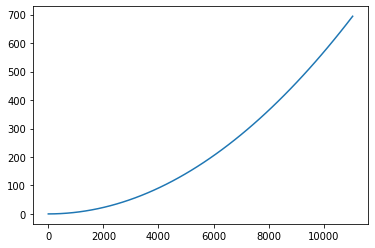

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
    elif j==7:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#        q0[(j-1)*node_N]=0 
# q0[7*node_N-1]= -0.00010522890316932987 # here
# q0[9*node_N-1]= 6.952842745988619e-09
# q0[11*node_N-1]=0.00010649100253301569 # here

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
q0=root

In [121]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [122]:
# x0_

In [123]:
# z0

In [124]:
# z0_

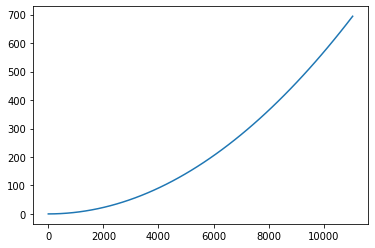

In [125]:
plt.plot(x0_, z0_)
plt.show()

In [126]:
# init=1
# for j in range(1,12):
#     if j==1:  
#         q0[(j-1)*node_N:j*node_N]=x0_
#     elif j==5:    
#         q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
# #         q0[(j-1)*node_N]=0
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 
# # q0[9*node_N-1]=0.13  # here
# q0[7*node_N-1]= -0.00010522890316932987 # here
# q0[9*node_N-1]= 6.952842745988619e-09
# q0[11*node_N-1]=0.00010649100253301569  # here

### Vessle Simulation

In [127]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [128]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [129]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [130]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

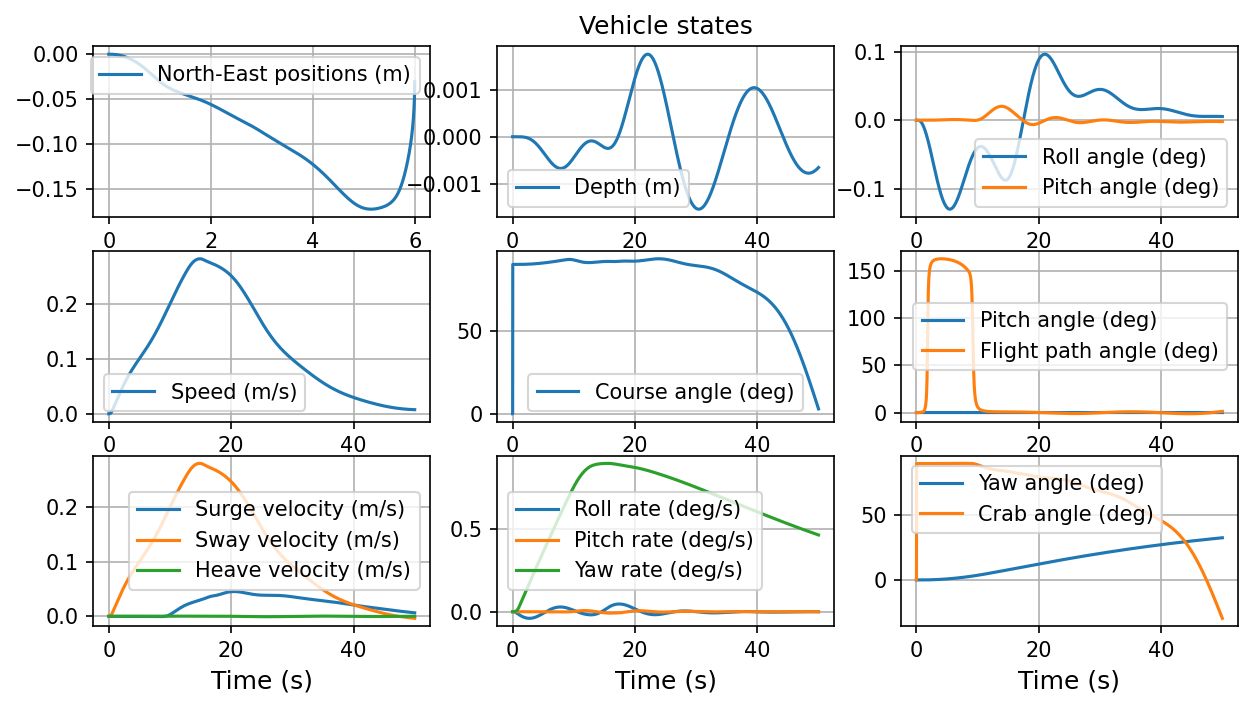

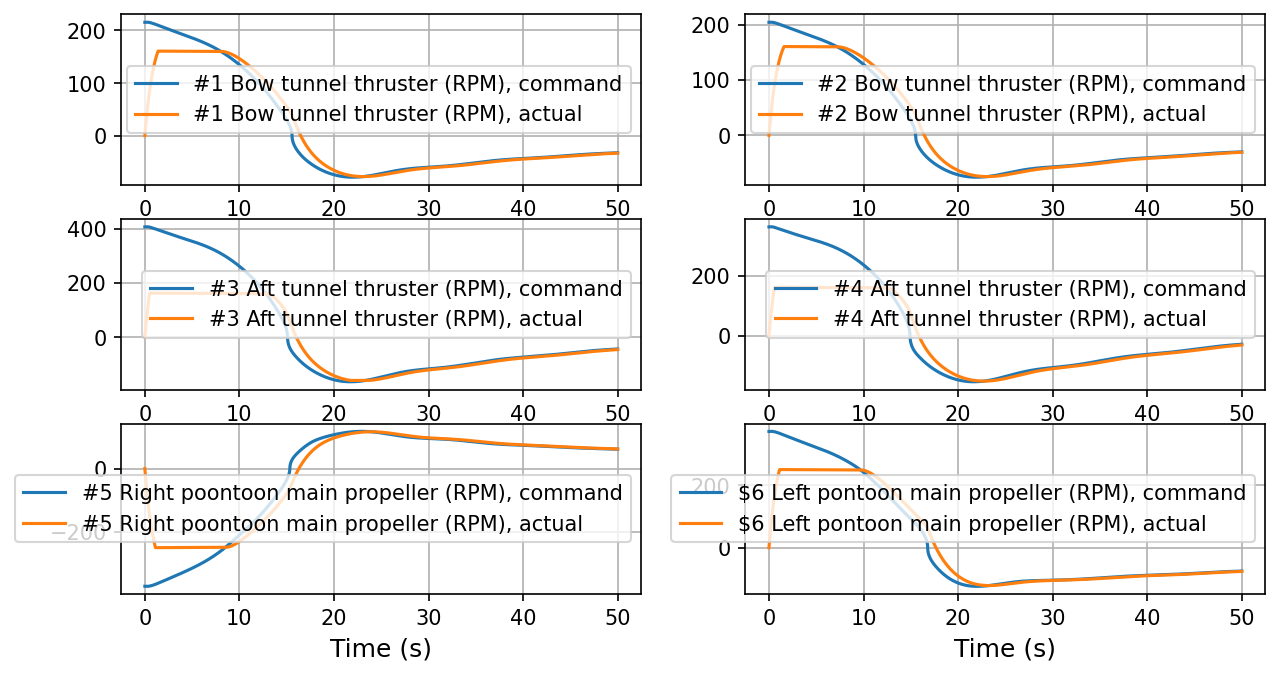

In [131]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [132]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

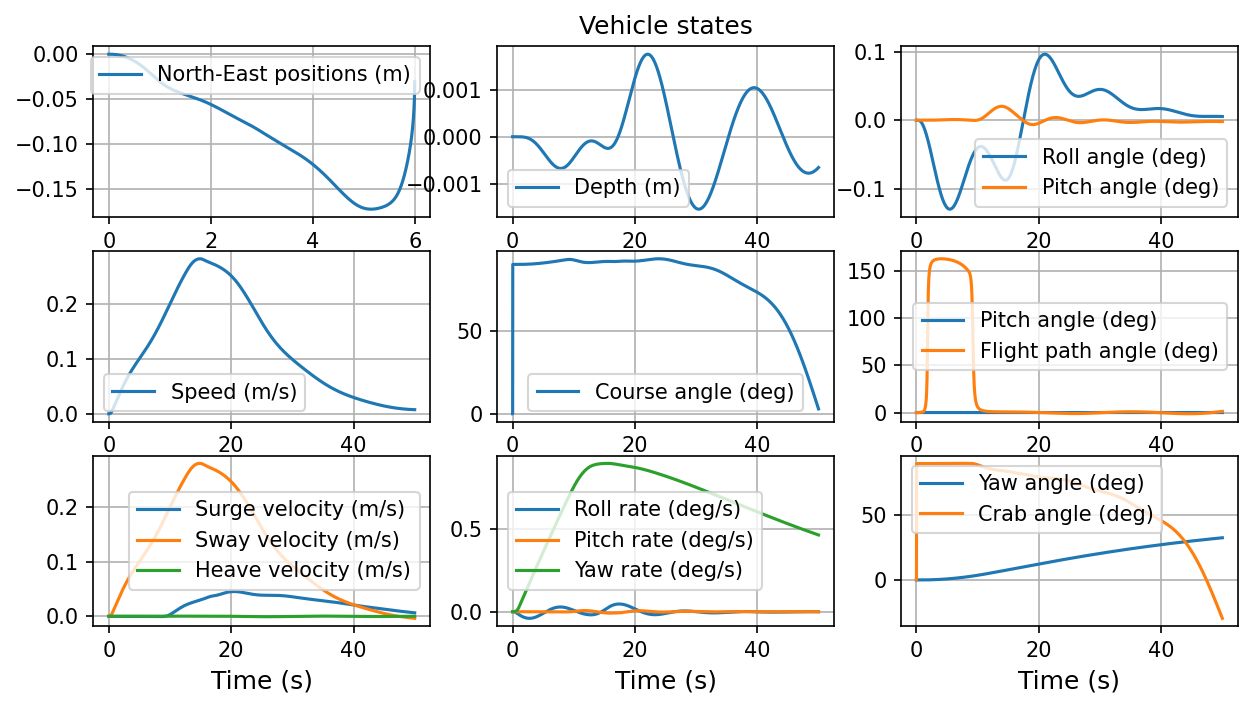

In [133]:
plotVehicleStates(simTime, simData, 3)

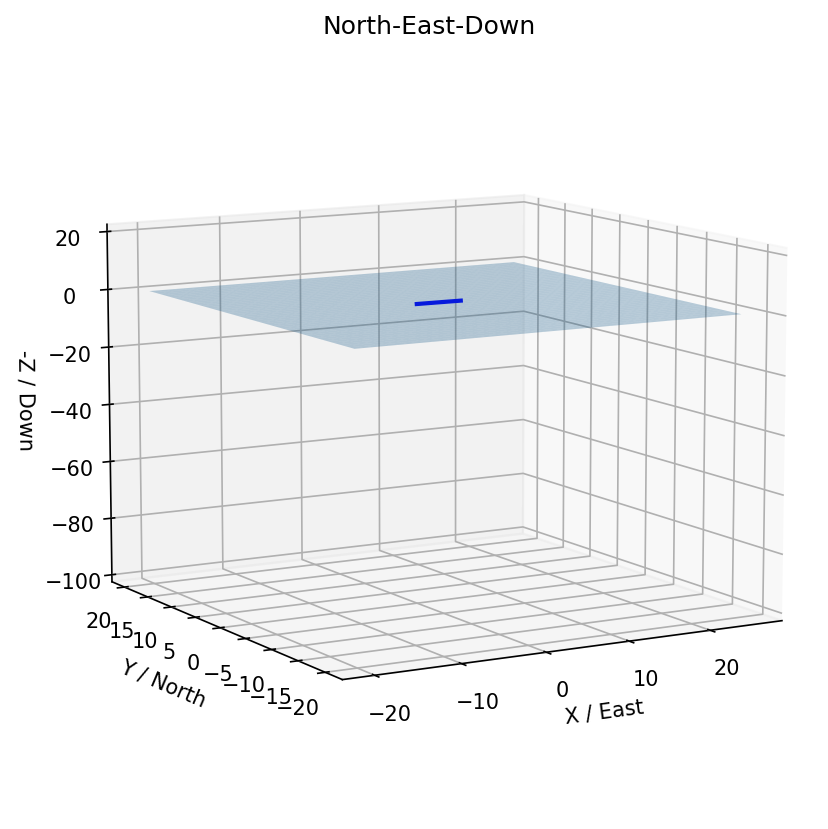

In [134]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [135]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [136]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [137]:
# Ws[0]*Ret[2]

In [138]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [139]:
idx=1/0.01

In [140]:
idx

100.0

In [141]:
ssa(simData[:, 3][int(idx)])

-0.00010522890316932987

In [142]:
ssa(simData[:, 4][int(idx)])

6.952842745988619e-09

In [143]:
ssa(simData[:, 5][int(idx)])

0.00010649100253301569

### Dynamics

In [144]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     force_schedule=1
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     print(tau_force)
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
  
    Z= (
        Z1
        + Z2 
        +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll) 

#     lll=length_p   
    
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
#     print(cum_d_inv[0])
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho[12])
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
#                  ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################
#     print(B[49])
#     print()

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111[-1])
    return A1111

In [145]:
# import scipy

In [146]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [147]:
# us=ode15s.integrate(10)

In [305]:
tspan = (0., 0.09)

In [306]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:19.532893


In [307]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init) and force_schedule 

# the main problem of the model is that it accelirates too much
# the hack increases the mass, the greater the mass the lesser the  acceleration
# the force_schedule affects the force, the lesser the force the lesser the  acceleration
# bc set conditions on how much force from the vessel should be applied to counteract the movement because of bc

# too fast acceleration leads to solution divergence in short amount of time

### Results

In [308]:
fin=us

In [309]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1010
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 8.34804191e-09, 4.64531448e-08, 2.05001558e-07,
       8.18403273e-07, 3.12846280e-06, 1.17698045e-05, 4.40480327e-05,
       1.64574102e-04, 6.15030800e-04, 1.28533227e-03, 1.95563375e-03,
       2.74205944e-03, 3.69801772e-03, 4.96252031e-03, 6.67542594e-03,
       8.41432551e-03, 1.00224329e-02, 1.15019673e-02, 1.30081118e-02,
       1.46716846e-02, 1.62124492e-02, 1.77532138e-02, 2.01451175e-02,
       2.14355084e-02, 2.27258993e-02, 2.46596501e-02, 2.62043322e-02,
       2.77490143e-02, 3.01852699e-02, 3.13805417e-02, 3.25758135e-02,
       3.46518987e-02, 3.61497072e-02, 3.76475157e-02, 3.97301600e-02,
       4.11261722e-02, 4.25221843e-02, 4.44042721e-02, 4.58995296e-02,
       4.73947871e-02, 4.91280315e-02, 5.05045822e-02, 5.18811329e-02,
       5.35863032e-02, 5.50106806e-02, 

In [310]:
t=fin.t

In [311]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


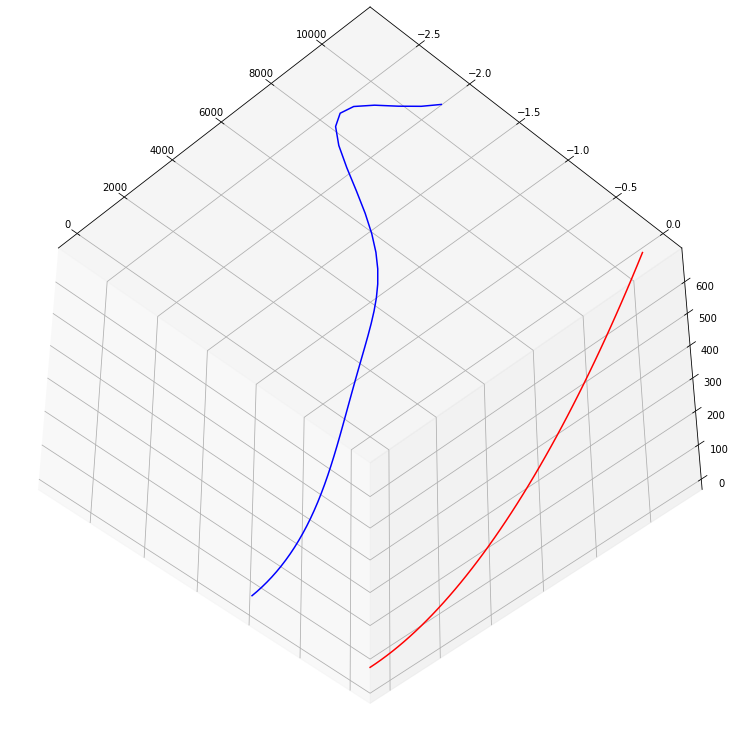

In [312]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [313]:
X,Y,Z

(array([-2.21559399e-01,  2.25261901e+02,  4.50753663e+02,  6.76251059e+02,
         9.01752650e+02,  1.12725760e+03,  1.35276542e+03,  1.57827579e+03,
         1.80378855e+03,  2.02930358e+03,  2.25482082e+03,  2.48034023e+03,
         2.70586178e+03,  2.93138540e+03,  3.15691098e+03,  3.38243834e+03,
         3.60796720e+03,  3.83349710e+03,  4.05902739e+03,  4.28455714e+03,
         4.51008506e+03,  4.73560940e+03,  4.96112785e+03,  5.18663746e+03,
         5.41213459e+03,  5.63761488e+03,  5.86307345e+03,  6.08850502e+03,
         6.31390425e+03,  6.53926588e+03,  6.76458477e+03,  6.98985565e+03,
         7.21507267e+03,  7.44022883e+03,  7.66531520e+03,  7.89032006e+03,
         8.11522797e+03,  8.34001875e+03,  8.56466696e+03,  8.78914248e+03,
         9.01341379e+03,  9.23745554e+03,  9.46126073e+03,  9.68485433e+03,
         9.90829985e+03,  1.01316894e+04,  1.03551156e+04,  1.05786381e+04,
         1.08022613e+04,  1.10251125e+04]),
 array([-1.16584047, -1.17121785, -1.1774060

In [314]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [315]:
us=fin.T

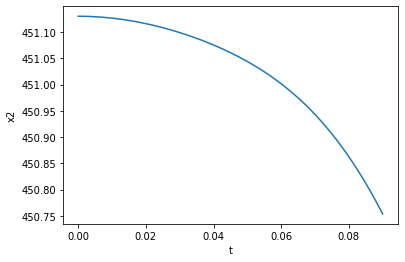

In [316]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

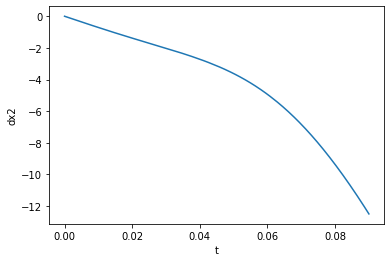

In [317]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

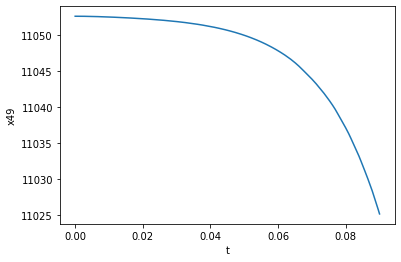

In [318]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

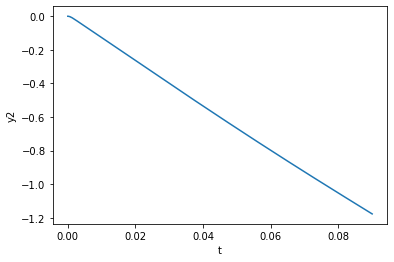

In [319]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

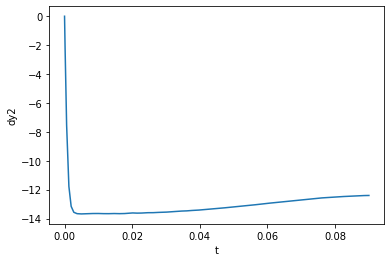

In [320]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

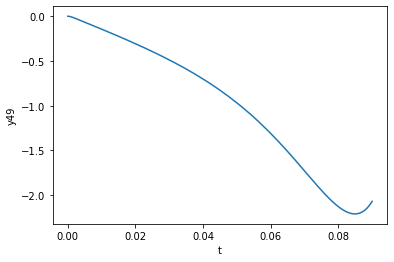

In [321]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

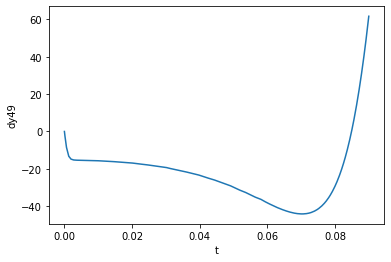

In [322]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

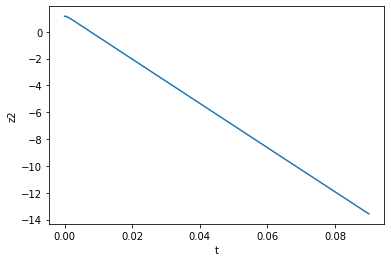

In [323]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

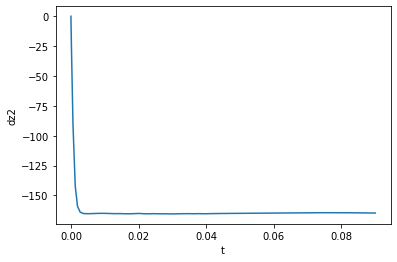

In [324]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

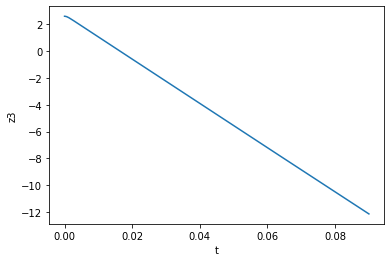

In [325]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

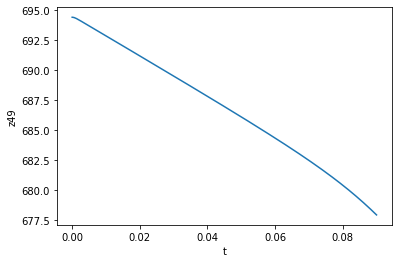

In [326]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

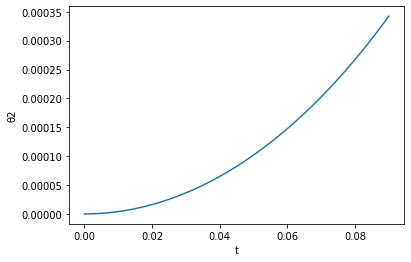

In [327]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

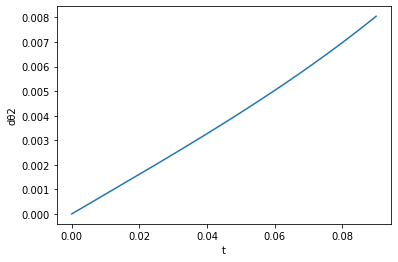

In [328]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

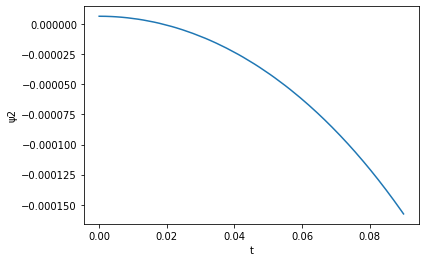

In [329]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

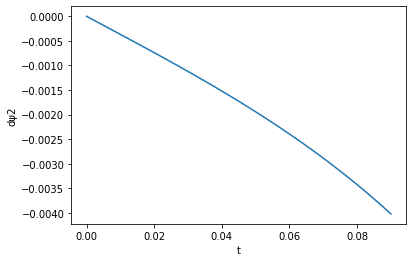

In [330]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()